In [33]:
# Data stuff
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import numpy as np
from itertools import compress
import csv

# handle Data points
import re
from collections import Counter

# NLP stuff
import nltk
from nltk.corpus import stopwords
import langdetect
import string
from wordcloud import WordCloud

# telegram
import telethon

# Load Data

In [12]:
data = pd.read_pickle("../data/data_medium.pkl")

In [13]:
data["sender"] = [str(s.user_id)  if type(s) is telethon.tl.types.PeerUser else "NaN" for s in data["sender"]]
data["reply_to"] = [float(r) for r in data["reply_to"]]
data["reply_to"] = [str(int(r)) if r.is_integer() else "NaN" for r in data["reply_to"]]
data["message_id"] = [str(i) for i in data["message_id"]]
data["contains_link"] = [m and "http" in m for m in data["message"]]
data["contains_link"] = data["contains_link"].replace("", False)
data["contains_link"] = data["contains_link"].fillna(False)

# Metrics for datasets

## Functions for different metrics

In [4]:
def calc_link_ratio(contains_link):
    """What proportion of messages contains links?"""
    return sum(contains_link)/len(contains_link)

def find_top_links(msgs, contains_link):
    """Returns ranked list of all sent links and their count."""
    msgs = list(compress(msgs, contains_link))
    regex = r"https?://((www|m)\.)?([^\s/]+\.\w{2,8})/"
    links = []
    for msg in msgs:
        find = re.findall(regex, msg)
        for f in find:
            links.append(f[2])
    links = Counter(links)
    links = [(l, c) for l,c in links.items()]
    links.sort(key=lambda x: x[1], reverse=True)
    return links 

In [5]:
def calc_sender_stats(senders):
    """Returns dictionary containing metrics regarding senders."""
    info = {}
    count = Counter(senders)
    info["total_senders"] = len(count)
    
    vals = sorted(count.values())
    info["counts"] = vals
    info["mean"] = sum(vals)/len(vals)
    if len(vals)%2 != 0:
        info["median"] = vals[len(vals)//2]
    else:
        f = len(vals)//2
        info["median"] = (vals[f] + vals[f+1])/2
    return info

In [6]:
def calc_speed(time):
    """Returns msgs/hour."""
    time = list(time)
    hours = (time[0] - time[-1]).total_seconds()/60/60
    speed = len(time)/hours
    return speed

def get_lofi_times(times, resolution=1., start=None):
    """Reformat times so it can be plottet in a more comprehensible way.
    resoltion sets the number of hours that should be grouped together, preferrably should be n where 24%n == 0."""
    lofi_times = []
    for t in times:
        if start and t < start:
            continue
        h = (t.hour//resolution) * resolution
        lofi_t = t.replace(minute=0, second=0, hour=h)
        lofi_times.append(lofi_t)
    return lofi_times

In [19]:
def calc_answer_ratio(reply_to):
    """Return answers/msgs"""
    not_answers = list(reply_to).count("NaN")
    answer_ratio = 1-(not_answers/len(reply_to))
    return answer_ratio

## Inspect Data

In [10]:
groups = data.index.get_level_values(0).unique().tolist()

### answer ratio

[0.41862999999999995, 0.15938575589091875, 0.50137, 0.84341]


<ipython-input-36-3ac01559d29a>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.set_major_formatter(PercentFormatter(xmax=1.))


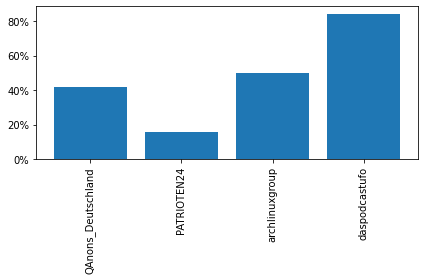

In [36]:
ar = [calc_answer_ratio(data.xs(g)["reply_to"]) for g in groups]
print(ar)
plt.bar([0,1,2,3], ar, tick_label=groups)
plt.xticks(rotation=90)
plt.axes().yaxis.set_major_formatter(PercentFormatter(xmax=1.))

plt.tight_layout()

plt.savefig("../figures/answer_ratio.png", dpi=150)

    

### Show top posted links

In [9]:
for g in groups:
    this_data = data.xs(g)
    print(g, calc_link_ratio(this_data["contains_link"]))

NameError: name 'groups' is not defined

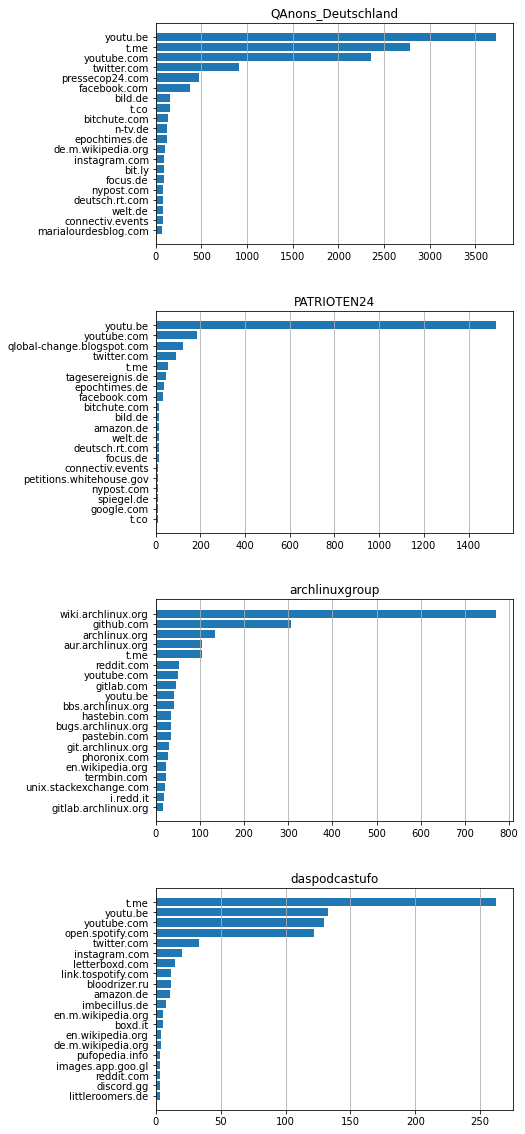

In [41]:
fig, axes = plt.subplots(len(groups), figsize=(6.4, len(groups)*5))

for group, ax in zip(groups, axes):
    this_data=data.xs(group)
    top_links = find_top_links(this_data["message"], this_data["contains_link"])
    n = 20
    labels, vals = zip(*top_links[:n])
    labels = list(reversed(labels))
    vals = list(reversed(vals))
    x = [i for i in range(n)]
    ax.barh(x, vals, tick_label=labels)
    ax.set_title(group)
    ax.grid(axis="x")

fig.subplots_adjust(hspace=.3)
fig.savefig("../figures/top_links.png", bbox_inches="tight", dpi=150)

### Inspect Senders

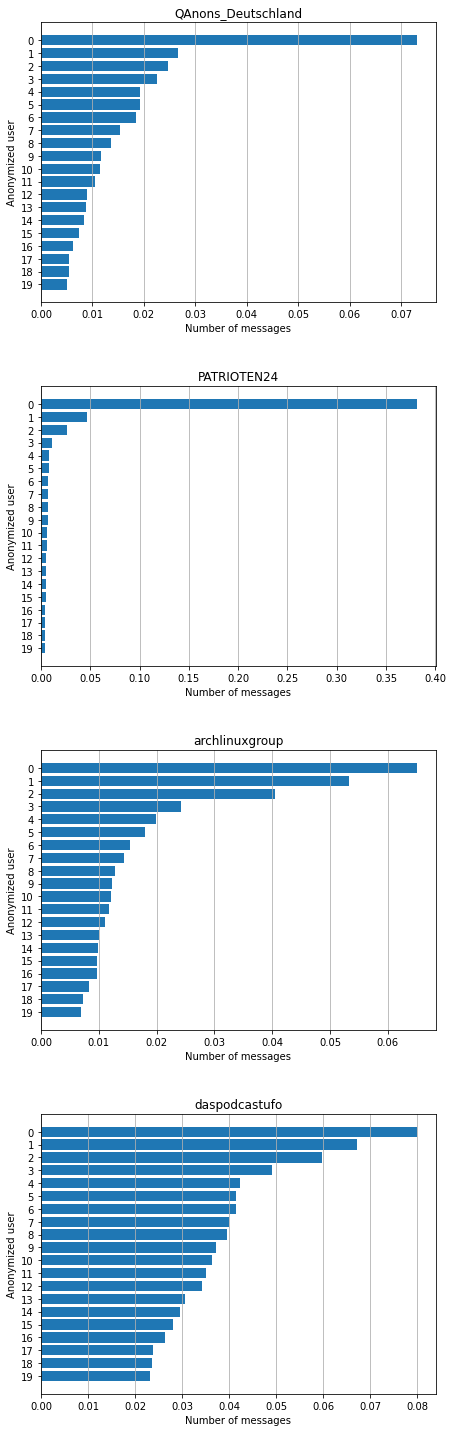

In [40]:
fig, axes = plt.subplots(len(groups), figsize=(6.4, len(groups)*5))

for group, ax in zip(groups, axes):
    this_data=data.xs(group)
    sender_stats = calc_sender_stats(this_data["sender"])
    n = 20
    x = [i for i in range(n)]
    counts = sender_stats["counts"]
    props = [c/len(this_data) for c in counts]
    
    # horizonal barplot shows how many messages were sent by specific users
    ax.barh(x, props[-n:], tick_label=list(reversed(x)), color="C0")
    ax.set_ylabel("Anonymized user")
    ax.set_xlabel("Number of messages")
    ax.set_title(group)
    ax.grid(axis="x")

    

fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.savefig("../figures/senders.png", dpi=150)

### Messages over time

#### Avg msgs per hour

In [23]:
for group in groups:
    this_data = data.xs(group)
    last_week = pd.Timestamp(year=2020, month=10, day=15, tz="UTC")
    times_last_week = [t for t in this_data["time"] if t >= last_week]
    print(group, calc_speed(times_last_week))

QAnons_Deutschland 129.12547669868925
PATRIOTEN24 2.3973287448028753
archlinuxgroup 17.973341109482554
daspodcastufo 63.84191805762585


#### msgs per day over time

In [13]:
start = pd.Timestamp(year=2020, month= 10, day=17, hour = 12, tz="UTC")
lofi_times = {g: get_lofi_times(data.xs(g)["time"], resolution=24, start=None) for g in groups}

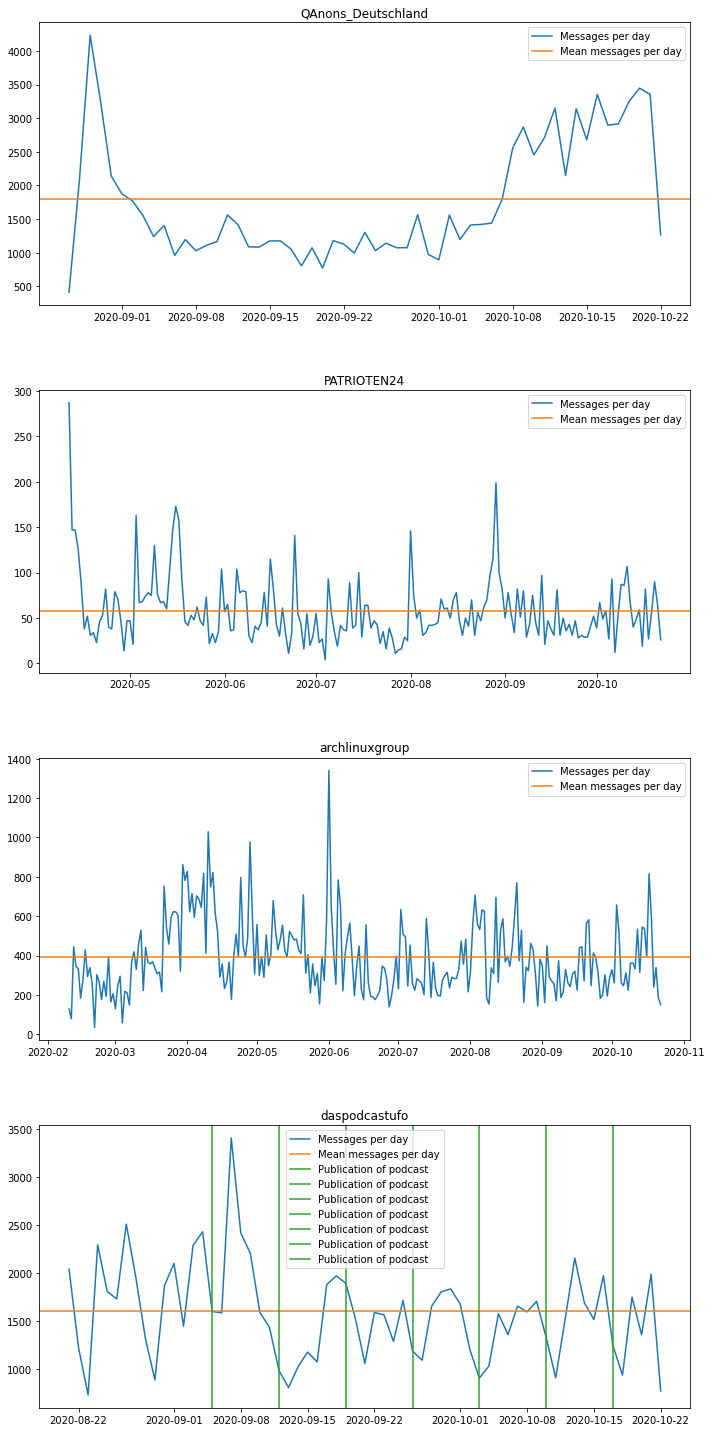

In [31]:
fig, axes = plt.subplots(len(groups), figsize=(10, len(groups)*5))

for group, ax in zip(groups, axes):
    times, counts = zip(*Counter(lofi_times[group]).items())
    ax.plot_date(times, counts, "b-", xdate=True, c="C0", label="Messages per day")
    ax.set_title(group)
    ax.axhline(calc_speed(data.xs(group)["time"])*24,c="C1", label="Mean messages per day")
    
    if group == "daspodcastufo":
        pub_dates = [(2020, 10, 17),
                     (2020, 10, 10),
                     (2020, 10, 3),
                     (2020, 9, 26),
                     (2020, 9, 19),
                     (2020, 9, 12),
                     (2020, 9, 5)]
        for y, m, d in pub_dates:
            ax.axvline(x=pd.Timestamp(year=y, month=m, day=d, tz="UTC"), color="C2", label="Publication of podcast" )
    ax.legend()


fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.savefig("../figures/time.png", dpi=150)

In [38]:
for g in groups:
    print(g, len(data.xs(g)))

QAnons_Deutschland 100000
PATRIOTEN24 11331
archlinuxgroup 100000
daspodcastufo 100000


### Most frequent words/ phrases

#### Wordclouds

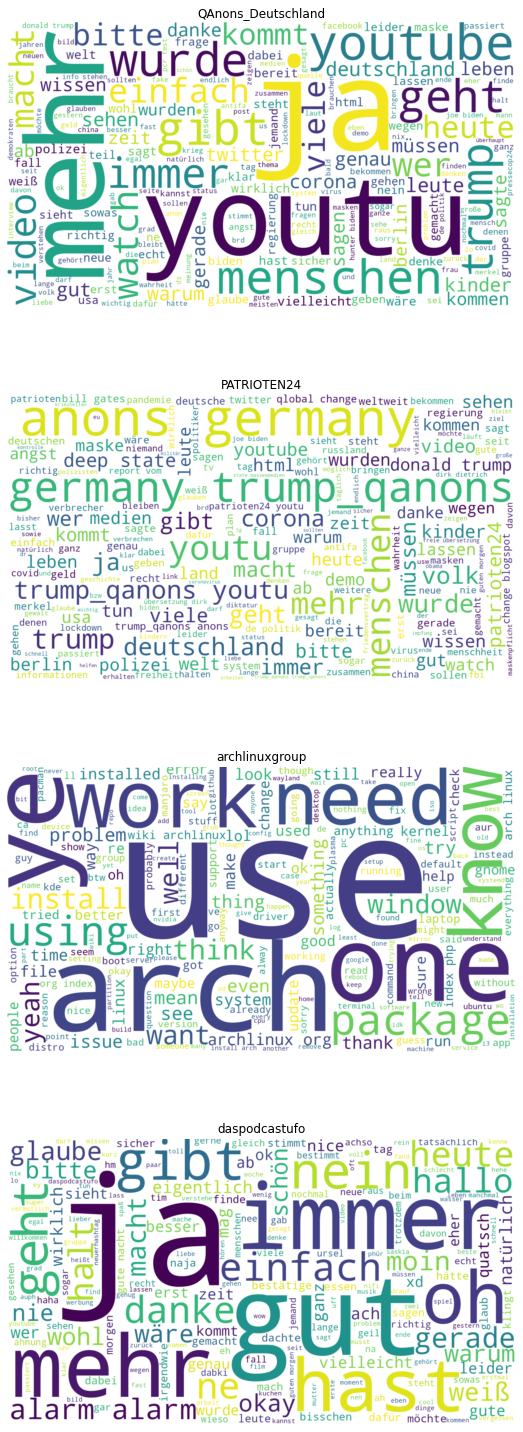

In [59]:
sw = {"german": set(stopwords.words("german")), "english": set(stopwords.words("english"))}
additions = {"„", "“", "..", "...", "....", "''", "html", "schon", "mal", "https", "``", "--", "``", "'s", "n't", "'m"}
sw["german"].update(additions)
sw["english"].update(additions)
lang = {"de":"german", "en":"english"}

fig, axes = plt.subplots(len(groups), figsize=(10, len(groups)*5))
all_tokens = {}

for group, ax in zip(groups, axes):
    msgs = data.xs(group)["message"]
    msgs = [m for m in msgs if m is not None]
    plain_text = " ".join(msgs).lower()
    this_lang = lang[langdetect.detect(plain_text)]
    tokens = nltk.word_tokenize(plain_text, language=this_lang)
    tokens = [t for t in tokens if t not in sw[this_lang] and t not in string.punctuation]
    filtered_tokens = []
    for tok in tokens:
        if tok in sw[this_lang] or tok in string.punctuation:
            continue
        filtered_tokens.append(tok)
    
    all_tokens[group] = filtered_tokens
        
    new_text = " ".join(filtered_tokens)
    wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate(new_text)
    ax.imshow(wordcloud, interpolation = "bilinear")
    ax.axis("off")
    ax.set_title(group)

fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.savefig("../figures/wordcloud.png", dpi=150)

#### n-grams

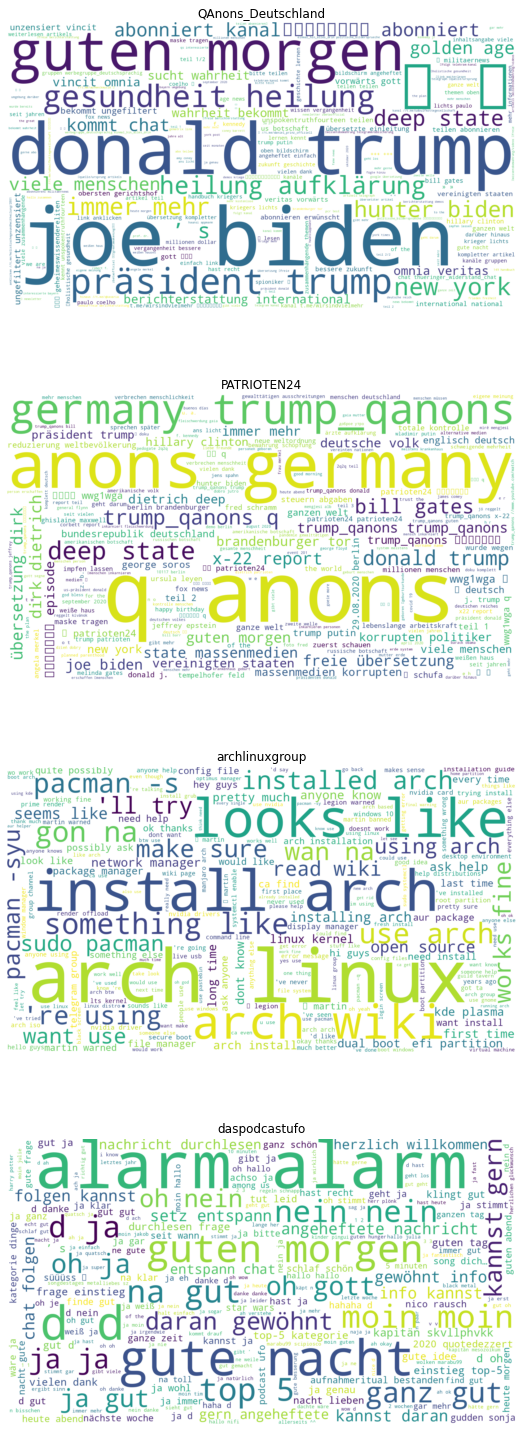

In [62]:

for group in groups:
    ngram_counts = [(ng, c) for ng, c in Counter(nltk.ngrams(all_tokens[group], n)).items()]
    ngram_counts.sort(key=lambda x: x[1], reverse=True)
    

fig, axes = plt.subplots(len(groups), figsize=(10, len(groups)*5))
n = 2

for group, ax in zip(groups, axes):
    ngram_counts = [(ng, c) for ng, c in Counter(nltk.ngrams(all_tokens[group], n)).items()]
    ngram_counts.sort(key=lambda x: x[1], reverse=True)
    ngram_count = {" ".join(ng): c for ng, c in ngram_counts}
    
    wordcloud = WordCloud(background_color="white", width=1920, height=1080).generate_from_frequencies(ngram_count)
    ax.imshow(wordcloud, interpolation = "bilinear")
    ax.axis("off")
    ax.set_title(group)

fig.tight_layout()
fig.subplots_adjust(hspace=.3)
fig.savefig("../figures/ngram_wordcloud.png", dpi=150)